In [8]:
cd ..

/home/CAMPUS/hdasari


In [9]:
import pickle

with open('/home/CAMPUS/hdasari/HyperNetworks/Battery/hypernetworks_dicts_bound_output_labels.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
with open('/home/CAMPUS/hdasari/HyperNetworks/Battery/Unet_predictions.pkl','rb') as f:
    unet_loaded_data = pickle.load(f)




In [10]:
bound_pixels = loaded_data[0]
hyp_pred_labels = loaded_data[1]
hyp_true_labels = loaded_data[2]
total_unet_pred_labels = unet_loaded_data[0]
total_unet_true_labels = unet_loaded_data[1]

In [11]:
print(len(bound_pixels))
print(len(hyp_pred_labels))
print(len(hyp_true_labels))
print(len(total_unet_pred_labels))
print(len(total_unet_true_labels))

40
40
40
40
40


In [12]:
bound_pixels = {
    key[0]: value for key, value in bound_pixels.items()
    
}
hyp_pred_labels = {
    key[0]: [int(v) for v in value]
    for key, value in hyp_pred_labels.items()
}
hyp_true_labels = {
    key[0]: [int(v) for v in value]
    for key, value in hyp_true_labels.items()
}


In [17]:
print(bound_pixels)

{'/home/CAMPUS/sgangadh1/projects/rl-batt-seg-snapshot-jan-2024/data/battery_2/test_images/130_38940_0.png': [[[tensor([143]), tensor([78])], [tensor([143]), tensor([88])], [tensor([144]), tensor([78])], [tensor([144]), tensor([88])], [tensor([145]), tensor([78])], [tensor([145]), tensor([88])], [tensor([146]), tensor([78])], [tensor([146]), tensor([88])], [tensor([147]), tensor([78])], [tensor([147]), tensor([88])], [tensor([148]), tensor([78])], [tensor([148]), tensor([88])], [tensor([149]), tensor([78])], [tensor([149]), tensor([88])], [tensor([150]), tensor([78])], [tensor([150]), tensor([88])], [tensor([151]), tensor([78])], [tensor([151]), tensor([88])], [tensor([152]), tensor([78])], [tensor([152]), tensor([88])], [tensor([153]), tensor([78])], [tensor([153]), tensor([88])], [tensor([143]), tensor([79])], [tensor([153]), tensor([79])], [tensor([143]), tensor([80])], [tensor([153]), tensor([80])], [tensor([143]), tensor([81])], [tensor([153]), tensor([81])], [tensor([143]), tenso

In [18]:
import torch
from torchmetrics.functional import jaccard_index
import numpy as np

def calculate_jaccard_for_boundary_pixels_unet(unet_pred_labels, unet_true_labels,hyp_pred_labels,hyp_true_labels, bound_pixels):
    """
    Calculate the Jaccard Index for boundary pixels using U-Net output.
    
    unet_pred_labels: Dictionary of predicted labels from U-Net (image path as key and tensor of predictions).
    unet_true_labels: Dictionary of true labels from U-Net (image path as key and tensor of ground truth).
    bound_pixels: List of pixel locations to consider for Jaccard calculation (boundary pixels).
    """
    unet_jaccard_scores = []
    hyp_jaccard_scores = []
    
    for image_path in unet_pred_labels:
        # Get the predicted and true labels for the current image from U-Net
        unet_pred_tensor = unet_pred_labels[image_path]
        unet_true_tensor = unet_true_labels[image_path]
        hyp_pred_tensor = hyp_pred_labels[image_path]
        hyp_true_tensor = hyp_true_labels[image_path]



        if isinstance(unet_pred_tensor, np.ndarray):
            unet_pred_tensor = torch.tensor(unet_pred_tensor)
        if isinstance(unet_true_tensor, np.ndarray):
            unet_true_tensor = torch.tensor(unet_true_tensor)
        if isinstance(hyp_pred_tensor, np.ndarray):
            hyp_pred_tensor = torch.tensor(hyp_pred_tensor)
        if isinstance(hyp_true_tensor, np.ndarray):
            hyp_true_tensor = torch.tensor(hyp_true_tensor)
        
        # Ensure tensors are long type for classification labels
        unet_pred_tensor = unet_pred_tensor.long()
        unet_true_tensor = unet_true_tensor.long()
        hyp_pred_tensor = hyp_pred_tensor
        hyp_true_tensor = hyp_true_tensor

        # print(image_path)
        pixel_locations = bound_pixels[image_path][0]
        # print(pixel_locations)
        
        # Get the predicted and true labels only for the boundary pixels
        unet_pred_values = []
        unet_true_values = []
        hyp_pred_values = []
        hyp_true_values = []
        
        for idx, (x, y) in enumerate(pixel_locations):
            if 0 <= x < unet_pred_tensor.shape[0] and 0 <= y < unet_pred_tensor.shape[1]:
                unet_pred_values.append(unet_pred_tensor[x, y].item())
                unet_true_values.append(unet_true_tensor[x, y].item())
                hyp_pred_values.append(hyp_pred_tensor[idx])
                hyp_true_values.append(hyp_true_tensor[idx])
       
        unet_pred_values_tensor = torch.tensor(unet_pred_values)
        unet_true_values_tensor = torch.tensor(unet_true_values)
        hyp_pred_values_tensor = torch.tensor(hyp_pred_values)
        hyp_true_values_tensor = torch.tensor(hyp_true_values)
 
        jaccard_unet = jaccard_index(unet_pred_values_tensor, unet_true_values_tensor, task="multiclass", num_classes=3)
        jaccard_hyp = jaccard_index(hyp_pred_values_tensor, hyp_true_values_tensor, task="multiclass", num_classes=3)
        
        unet_jaccard_scores.append(jaccard_unet.item())
        hyp_jaccard_scores.append(jaccard_hyp.item())
    
    avg_jaccard_score = sum(unet_jaccard_scores) / len(unet_jaccard_scores) if unet_jaccard_scores else 0
    avg_hyp_jaccard_score = sum(hyp_jaccard_scores) / len(hyp_jaccard_scores) if hyp_jaccard_scores else 0
    
    return avg_jaccard_score, unet_jaccard_scores, avg_hyp_jaccard_score, hyp_jaccard_scores


avg_jaccard, unet_jaccard_scores,avg_jaccard_score, hyp_jaccard_scores = calculate_jaccard_for_boundary_pixels_unet(total_unet_pred_labels, total_unet_true_labels, hyp_pred_labels, hyp_true_labels, bound_pixels)
print(f"Average Jaccard Index for Boundary Pixels (U-Net): {avg_jaccard}")
print(f"Average Jaccard Index for Boundary Pixels (Hypernetwork): {avg_jaccard_score}")


Average Jaccard Index for Boundary Pixels (U-Net): 0.455365246348083
Average Jaccard Index for Boundary Pixels (Hypernetwork): 0.40318600870668886


In [19]:
import torch
from torchmetrics.functional import jaccard_index
import numpy as np

def calculate_jaccard_for_boundary_pixels_unet(unet_pred_labels, unet_true_labels):
   
    unet_total_jaccard_scores = []
    
    for image_path in unet_pred_labels:
        # Get the predicted and true labels for the current image from U-Net
        unet_pred_tensor = unet_pred_labels[image_path]
        unet_true_tensor = unet_true_labels[image_path]



        if isinstance(unet_pred_tensor, np.ndarray):
            unet_pred_tensor = torch.tensor(unet_pred_tensor)
        if isinstance(unet_true_tensor, np.ndarray):
            unet_true_tensor = torch.tensor(unet_true_tensor)
        
        # Ensure tensors are long type for classification labels
        unet_pred_tensor = unet_pred_tensor.long()
        unet_true_tensor = unet_true_tensor.long()

        jaccard = jaccard_index(unet_pred_tensor, unet_true_tensor, task="multiclass", num_classes=3)
        
        unet_total_jaccard_scores.append(jaccard.item())
    
    avg_jaccard_score = sum(unet_total_jaccard_scores) / len(unet_total_jaccard_scores) if unet_total_jaccard_scores else 0
    
    return avg_jaccard_score, unet_jaccard_scores


avg_jaccard, unet_jaccard_scores = calculate_jaccard_for_boundary_pixels_unet(total_unet_pred_labels, total_unet_true_labels)
print(f"Average Jaccard Index for Full Image (U-Net): {avg_jaccard}")


Average Jaccard Index for Full Image (U-Net): 0.517246674746275


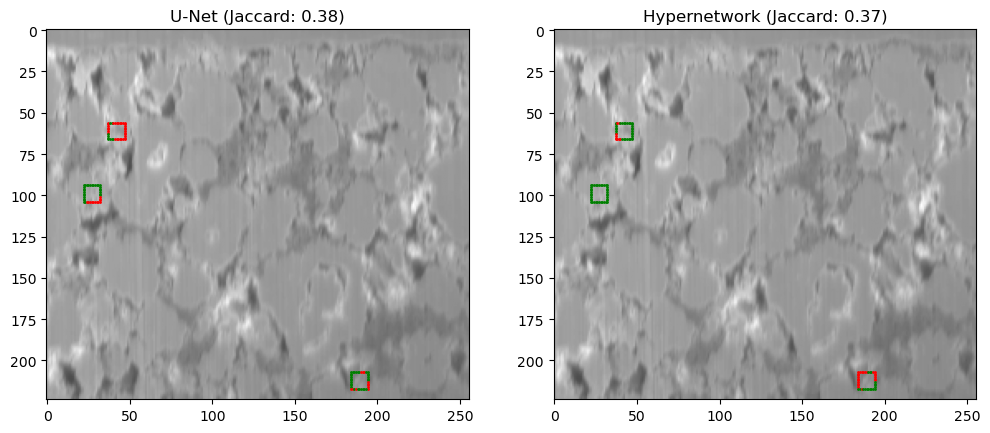

<Figure size 640x480 with 0 Axes>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_unet_predictions(img_path, pixel_locations, unet_true_labels, unet_preds, hyp_true, hyp_pred):
    
    img = Image.open(img_path).convert("L")
    
    img = np.array(img)

    unet_true_labels = unet_true_labels[img_path]
    unet_preds = unet_preds[img_path]
    pixel_locations = pixel_locations[img_path][0]
    hyp_true = hyp_true[img_path]
    hyp_pred = hyp_pred[img_path]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  
    
    ax[0].imshow(img, cmap="gray", alpha=0.7)  
    ax[1].imshow(img, cmap="gray", alpha=0.7)

    # ax[0].set_title("U-Net")
    # ax[1].set_title("Hypernetwork")
    # ax[0].axis("off")
    # ax[1].axis("off")

    unet_pred_values = []
    unet_true_values = []
    hyp_pred_values = []
    hyp_true_values = []
    
    # Get image dimensions for range check
    img_height, img_width = unet_true_labels.shape  

    for idx, (x, y) in enumerate(pixel_locations):
        # Check if the coordinates are within the valid range of the image
        if 0 <= x < img_height and 0 <= y < img_width:
            true_value = unet_true_labels[x, y]  
            pred_value = unet_preds[x, y] 
            hyp_true_value = hyp_true[idx]
            hyp_pred_value = hyp_pred[idx]
            unet_pred_values.append(unet_preds[x, y].item())
            unet_true_values.append(unet_true_labels[x, y].item())
            hyp_pred_values.append(hyp_pred[idx])
            hyp_true_values.append(hyp_true[idx])

            # Highlight correct and incorrect predictions
            if true_value != pred_value:
                ax[0].scatter(y, x, color="red", s=1)  # Incorrect predictions (red)
            else:
                ax[0].scatter(y, x, color="green", s=1)  # Correct predictions (green)

            if hyp_true_value != hyp_pred_value:
                ax[1].scatter(y, x, color="red", s=1)
            else:
                ax[1].scatter(y, x, color="green", s=1)

    # Show the plot
    unet_pred_values_tensor = torch.tensor(unet_pred_values)
    unet_true_values_tensor = torch.tensor(unet_true_values)
    hyp_pred_values_tensor = torch.tensor(hyp_pred_values)
    hyp_true_values_tensor = torch.tensor(hyp_true_values)
    jaccard_unet = jaccard_index(unet_pred_values_tensor, unet_true_values_tensor, task="multiclass", num_classes=3)
    jaccard_hyp = jaccard_index(hyp_pred_values_tensor, hyp_true_values_tensor, task="multiclass", num_classes=3)
    ax[0].set_title(f"U-Net (Jaccard: {jaccard_unet:.2f})")
    ax[1].set_title(f"Hypernetwork (Jaccard: {jaccard_hyp:.2f})")
    plt.show()
    plt.tight_layout()


img_path = '/home/CAMPUS/sgangadh1/projects/rl-batt-seg-snapshot-jan-2024/data/battery_2/test_images/130_38940_6.png'
visualize_unet_predictions(img_path, bound_pixels, total_unet_true_labels, total_unet_pred_labels, hyp_true_labels, hyp_pred_labels)


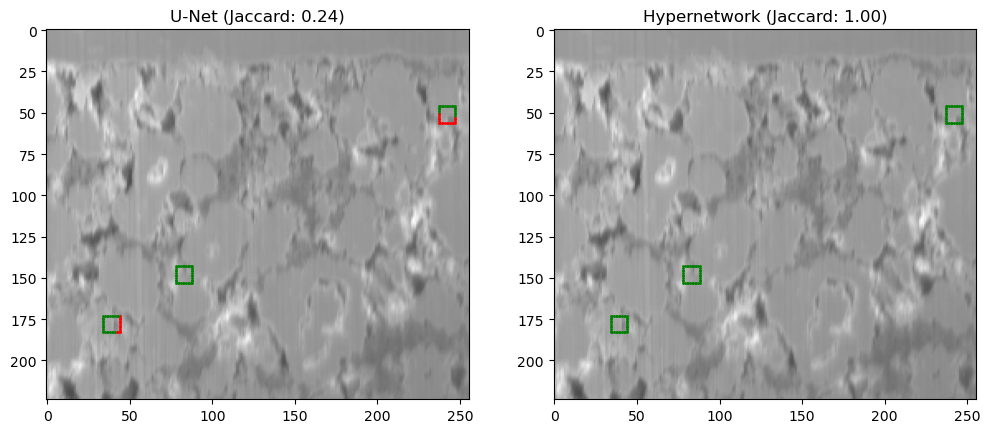

<Figure size 640x480 with 0 Axes>

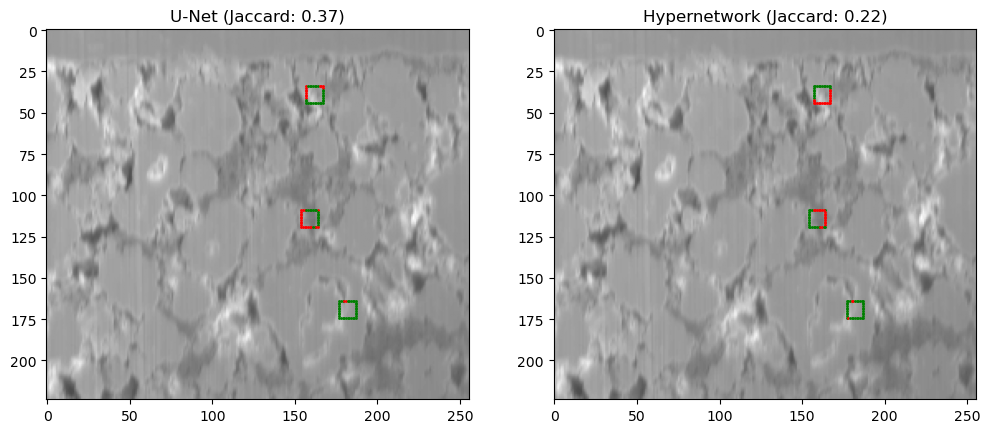

<Figure size 640x480 with 0 Axes>

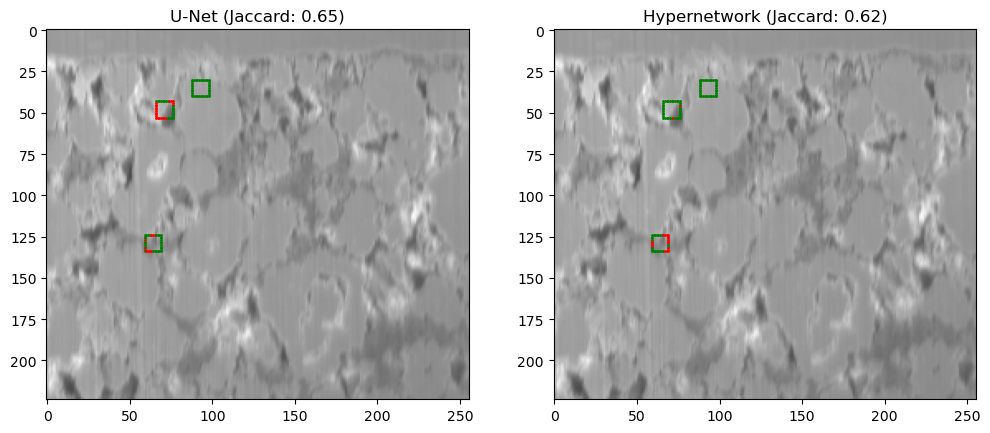

<Figure size 640x480 with 0 Axes>

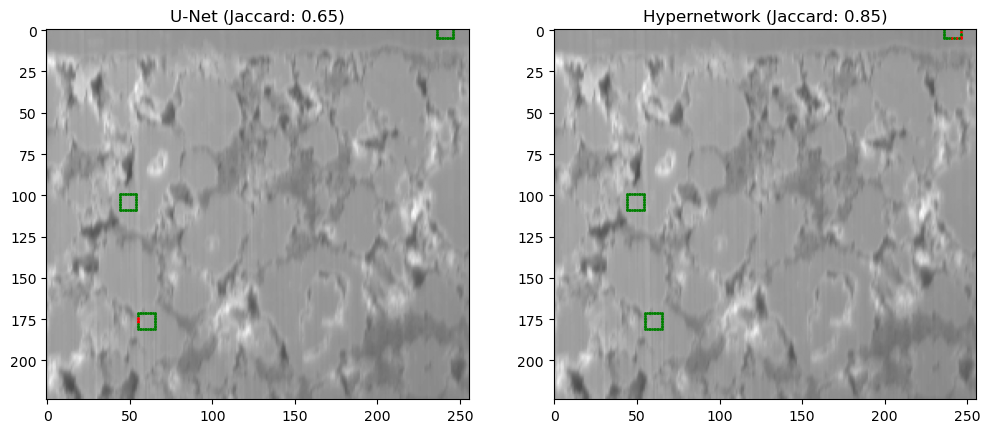

<Figure size 640x480 with 0 Axes>

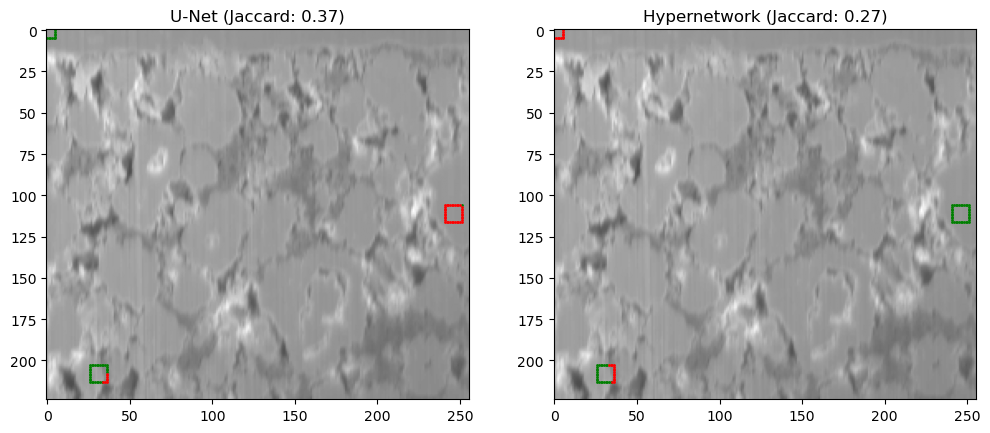

<Figure size 640x480 with 0 Axes>

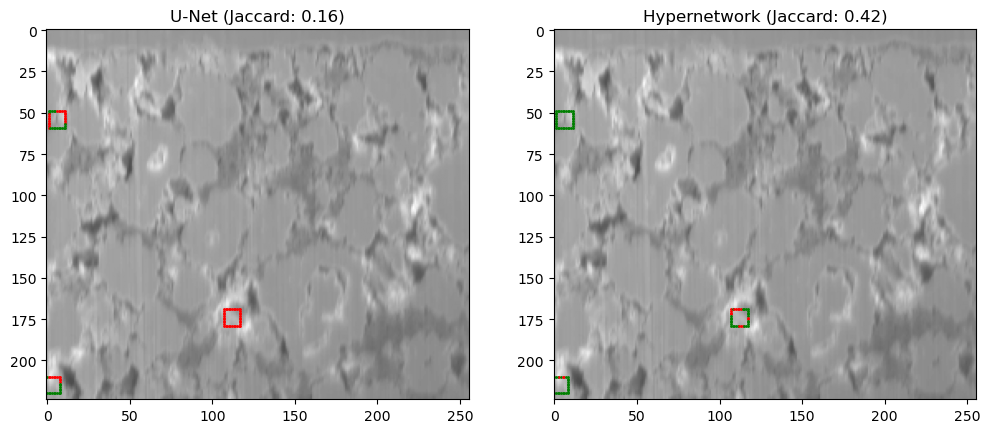

<Figure size 640x480 with 0 Axes>

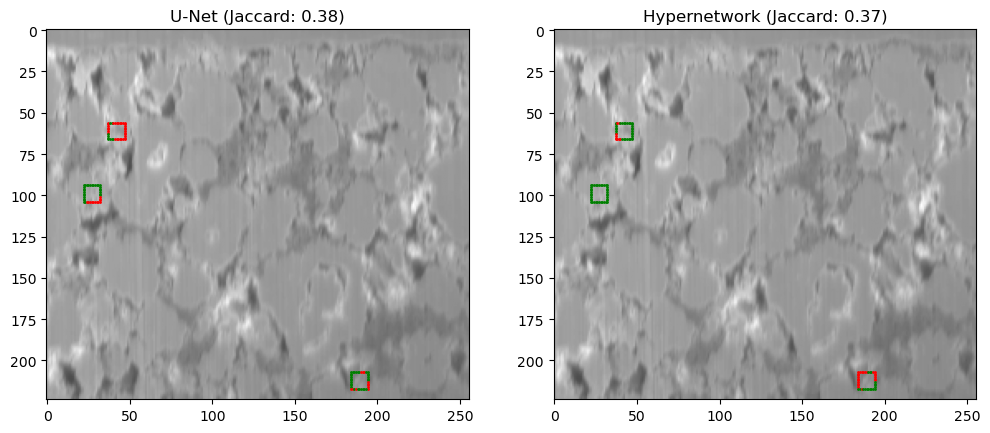

<Figure size 640x480 with 0 Axes>

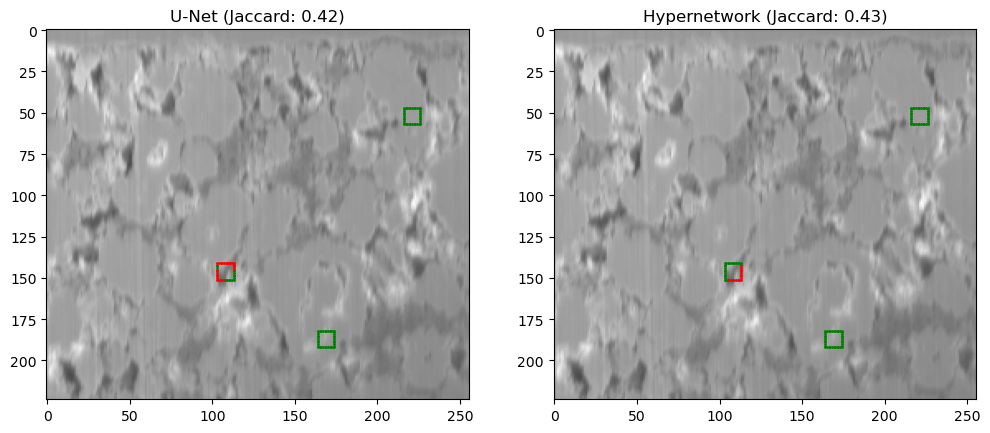

<Figure size 640x480 with 0 Axes>

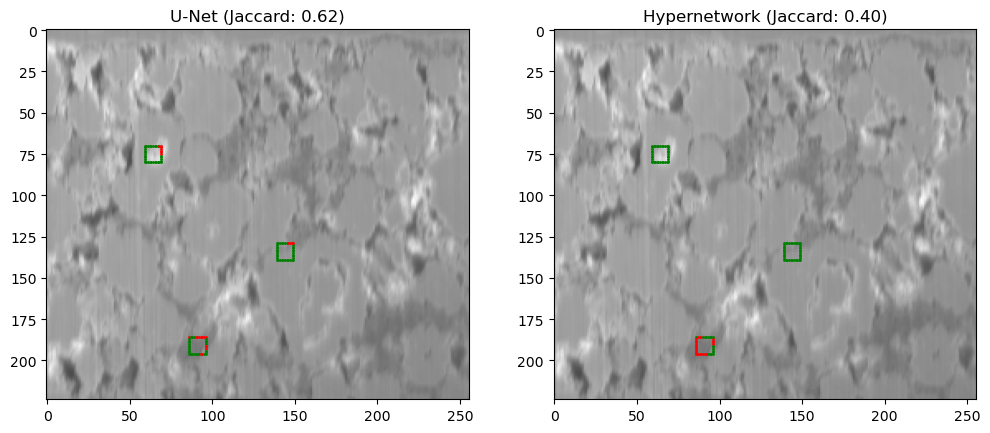

<Figure size 640x480 with 0 Axes>

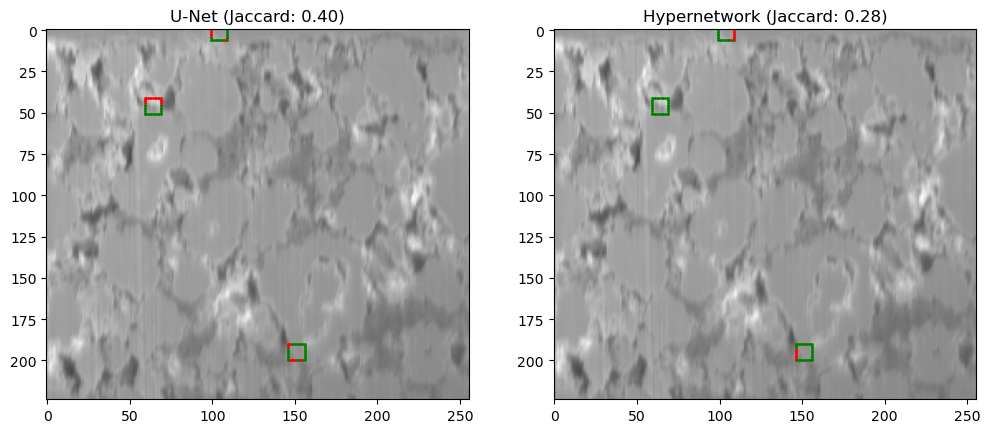

<Figure size 640x480 with 0 Axes>

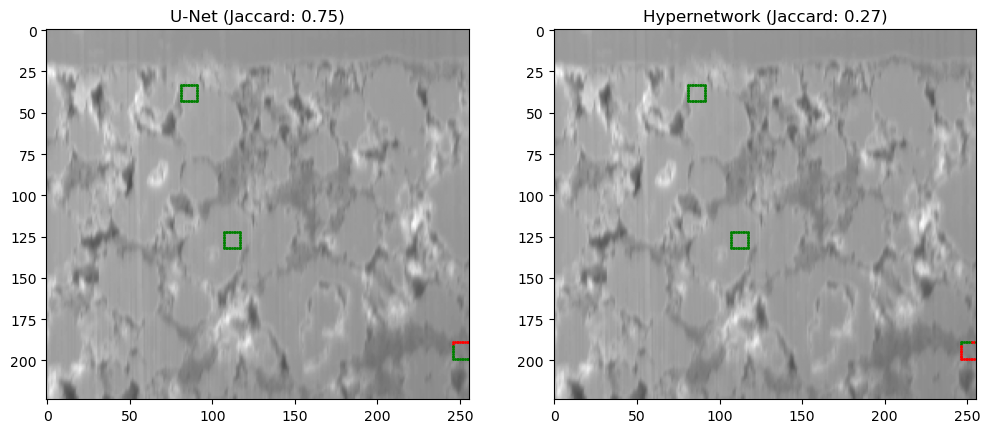

<Figure size 640x480 with 0 Axes>

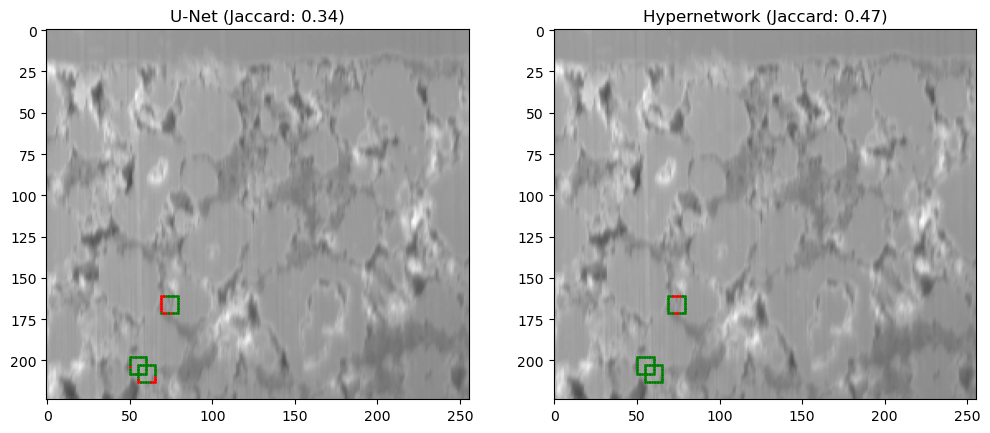

<Figure size 640x480 with 0 Axes>

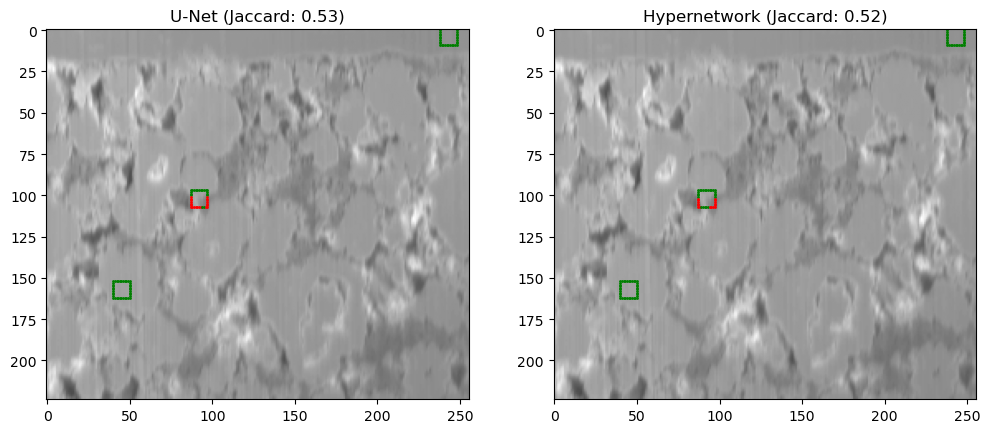

<Figure size 640x480 with 0 Axes>

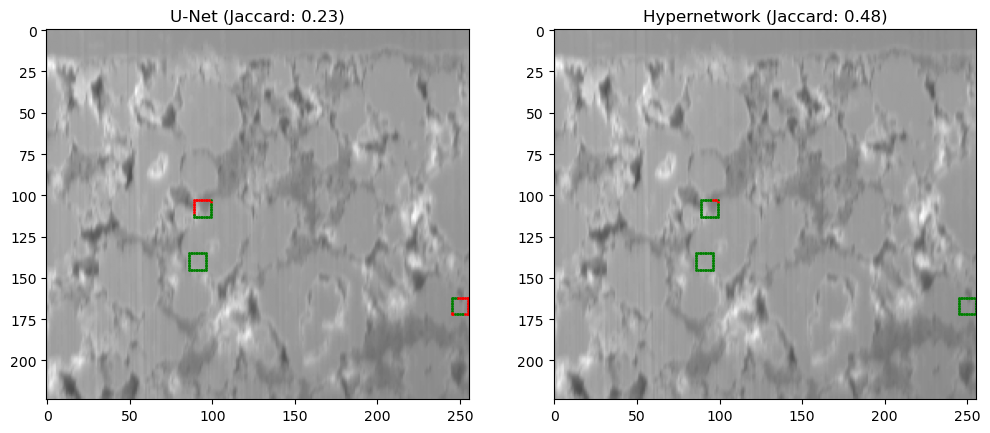

<Figure size 640x480 with 0 Axes>

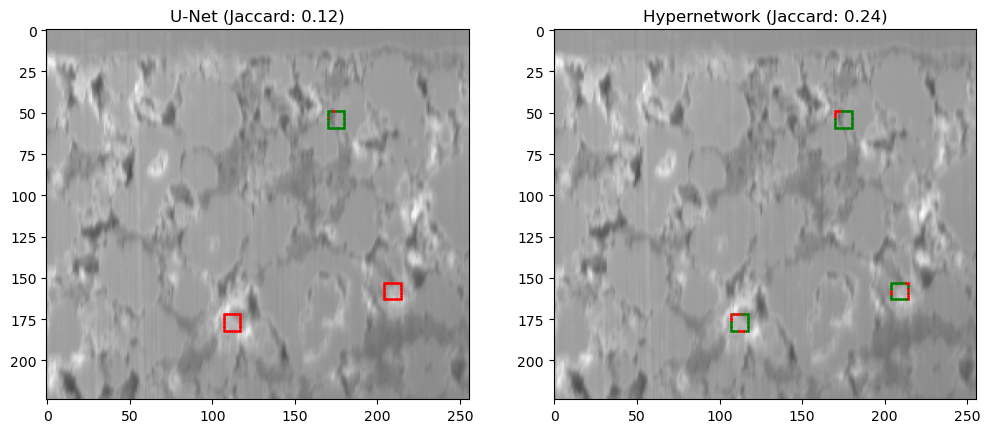

<Figure size 640x480 with 0 Axes>

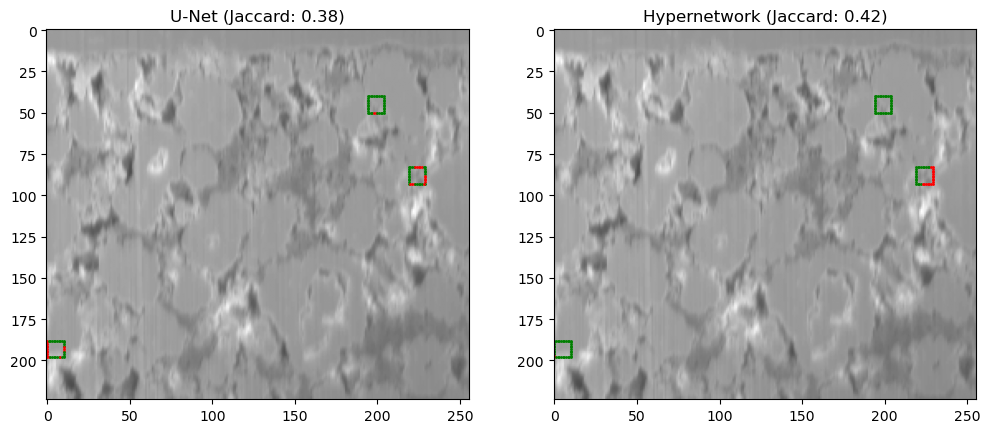

<Figure size 640x480 with 0 Axes>

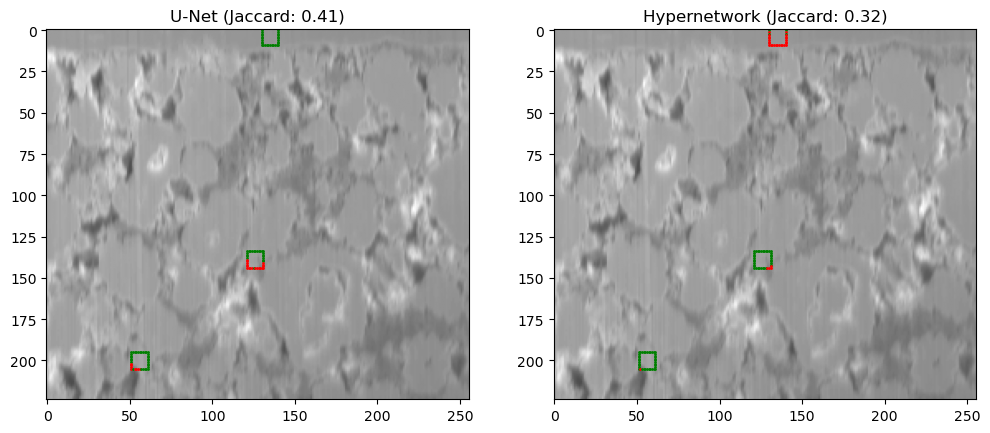

<Figure size 640x480 with 0 Axes>

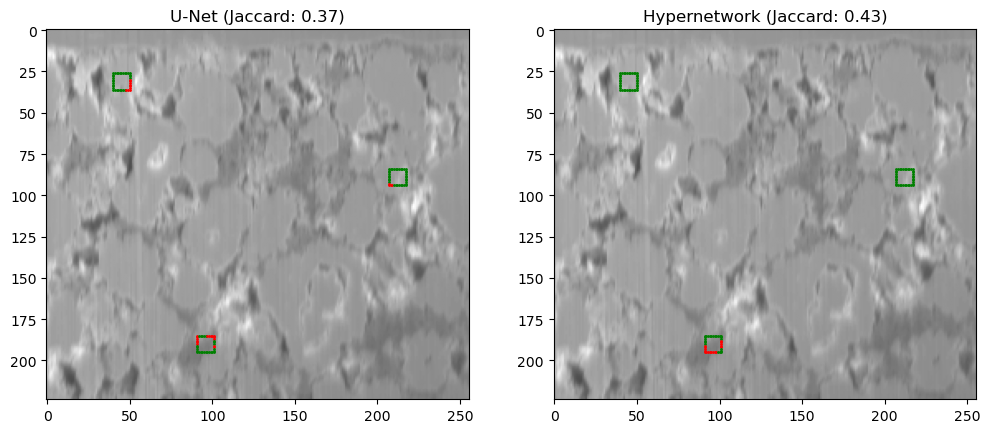

<Figure size 640x480 with 0 Axes>

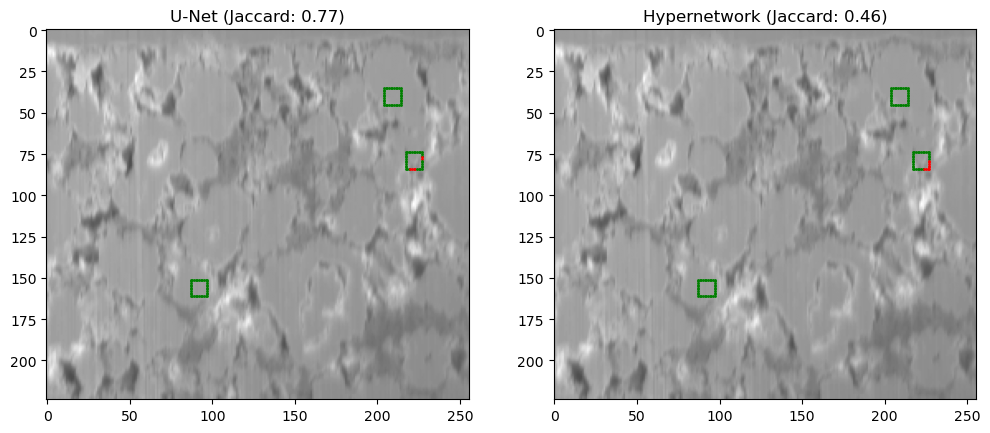

<Figure size 640x480 with 0 Axes>

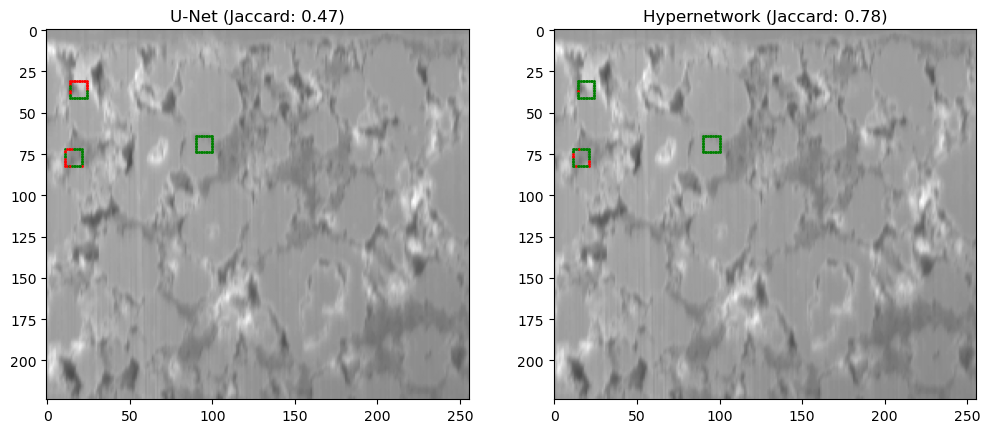

<Figure size 640x480 with 0 Axes>

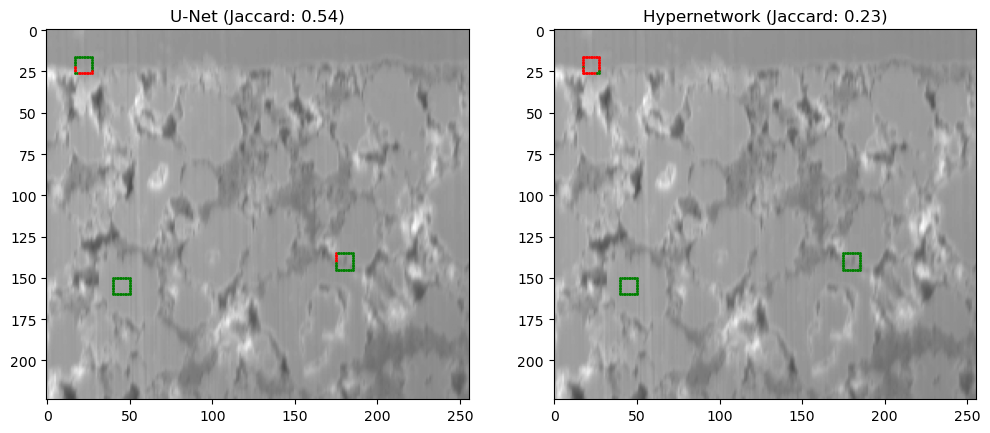

<Figure size 640x480 with 0 Axes>

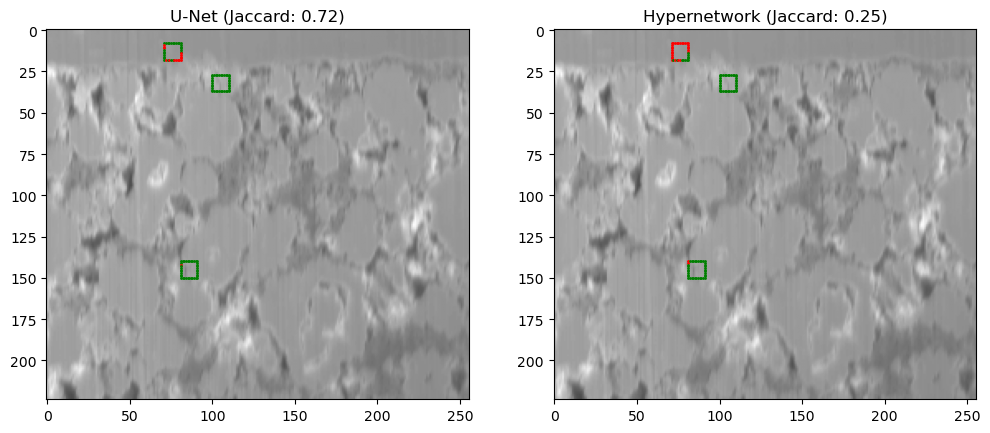

<Figure size 640x480 with 0 Axes>

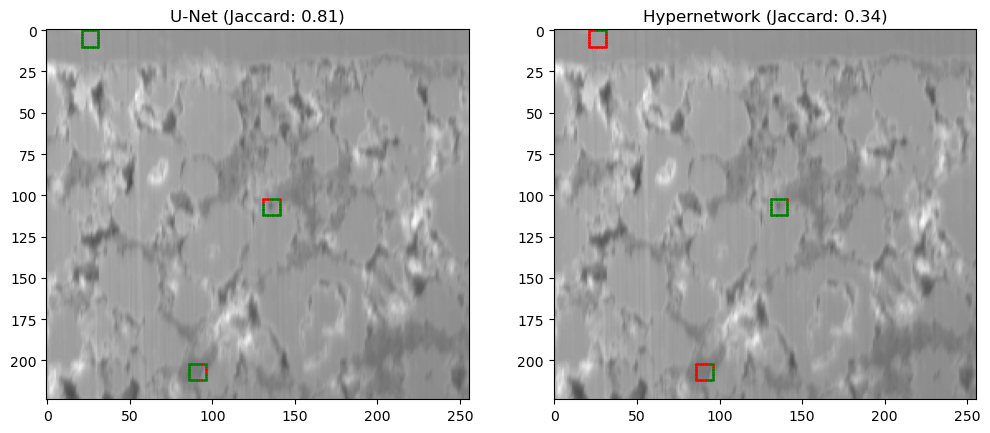

<Figure size 640x480 with 0 Axes>

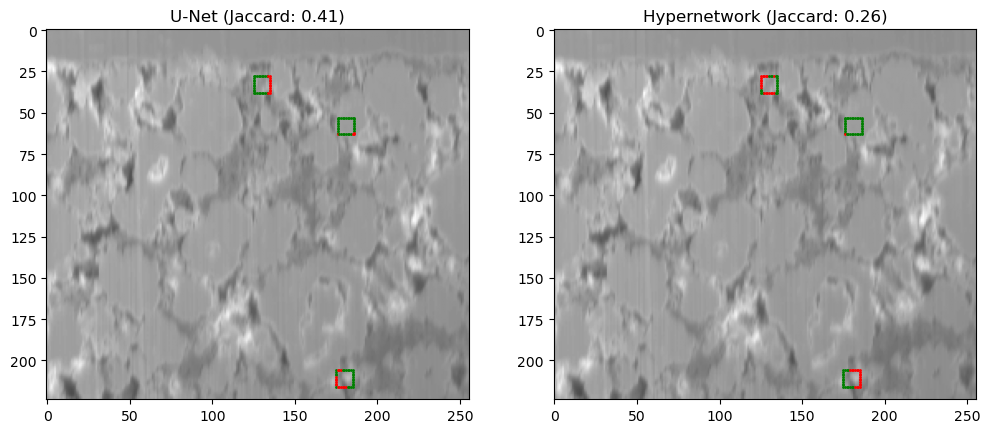

<Figure size 640x480 with 0 Axes>

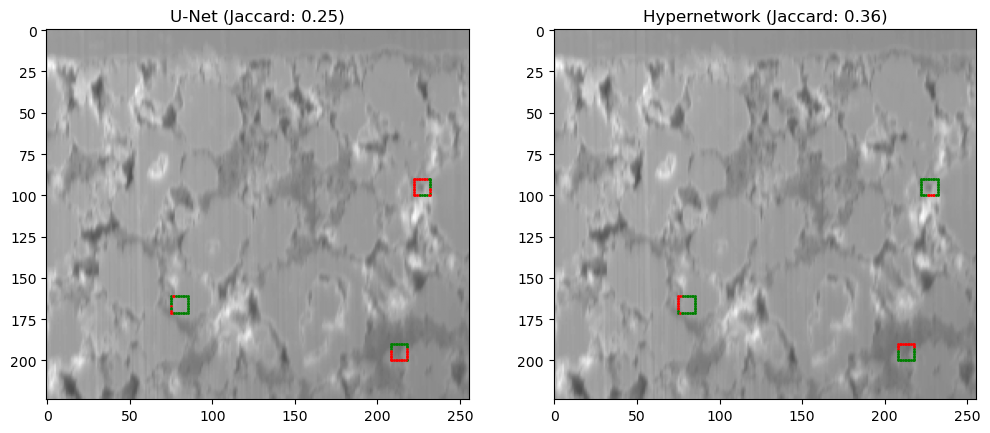

<Figure size 640x480 with 0 Axes>

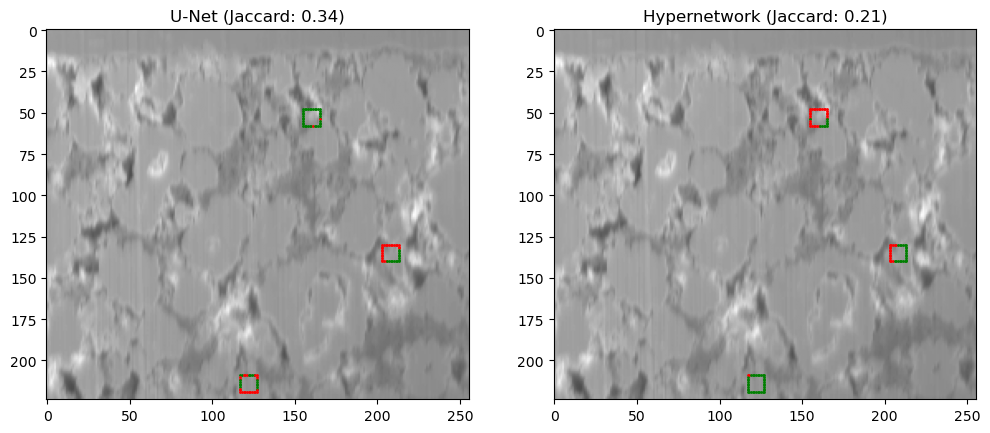

<Figure size 640x480 with 0 Axes>

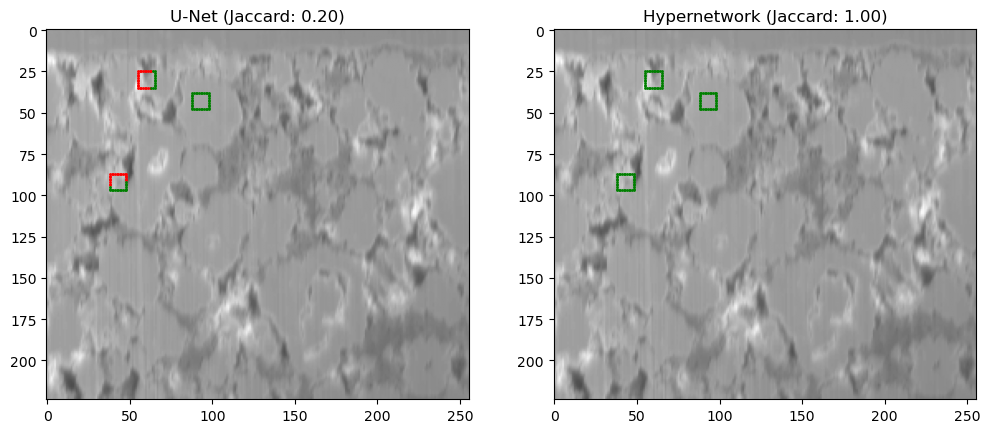

<Figure size 640x480 with 0 Axes>

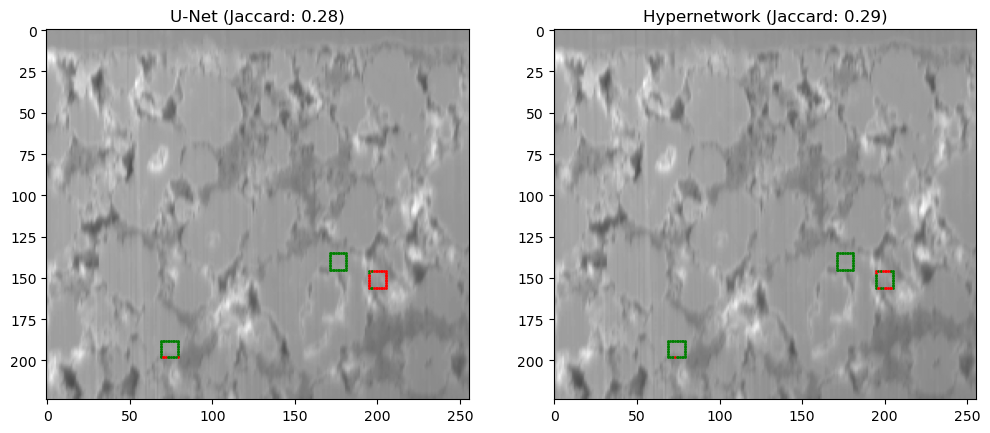

<Figure size 640x480 with 0 Axes>

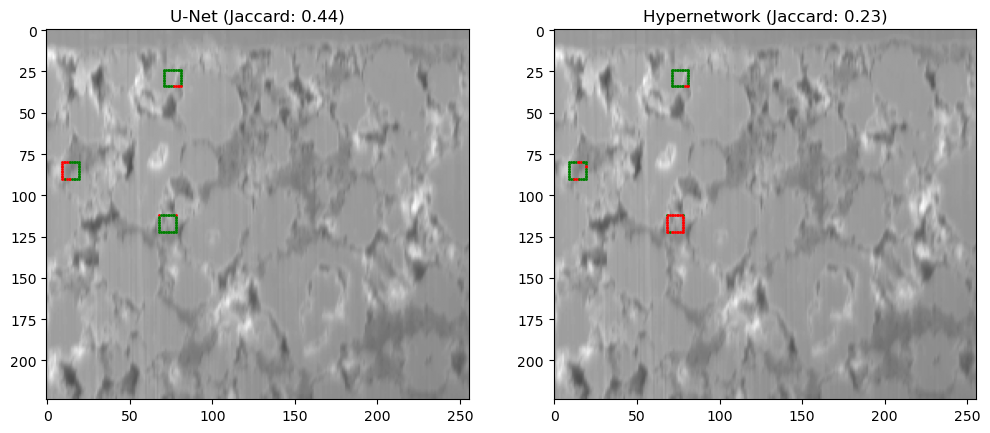

<Figure size 640x480 with 0 Axes>

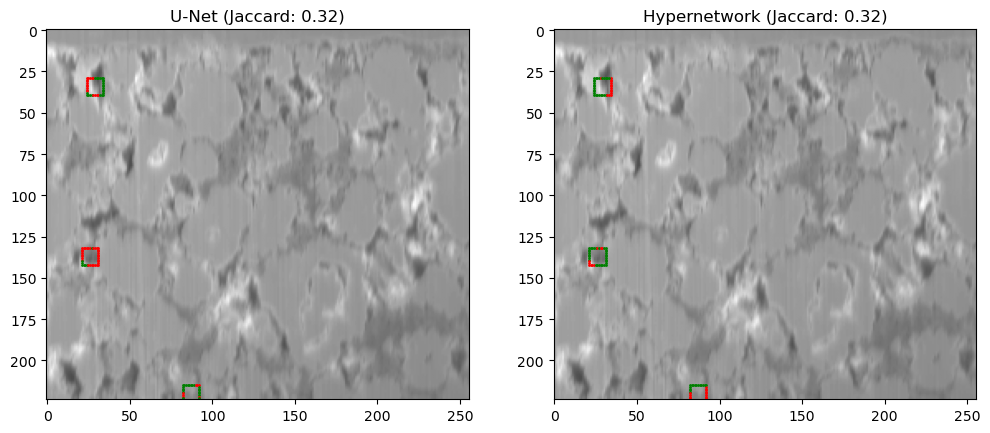

<Figure size 640x480 with 0 Axes>

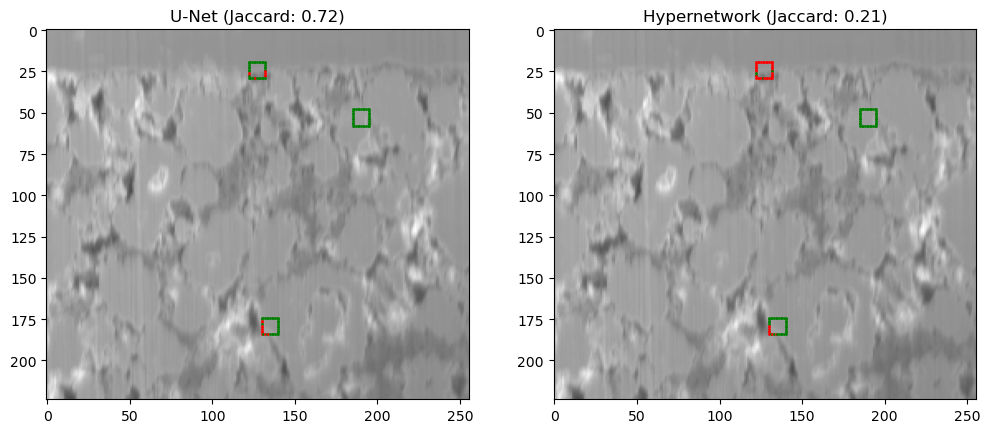

<Figure size 640x480 with 0 Axes>

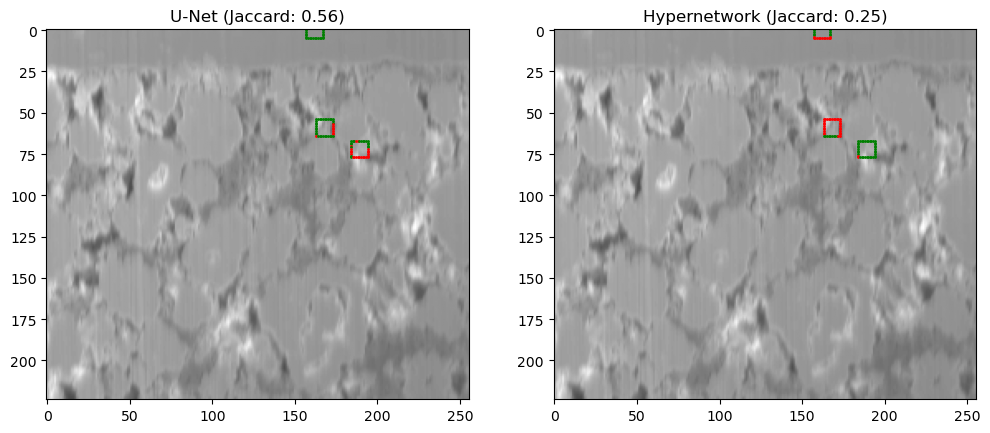

<Figure size 640x480 with 0 Axes>

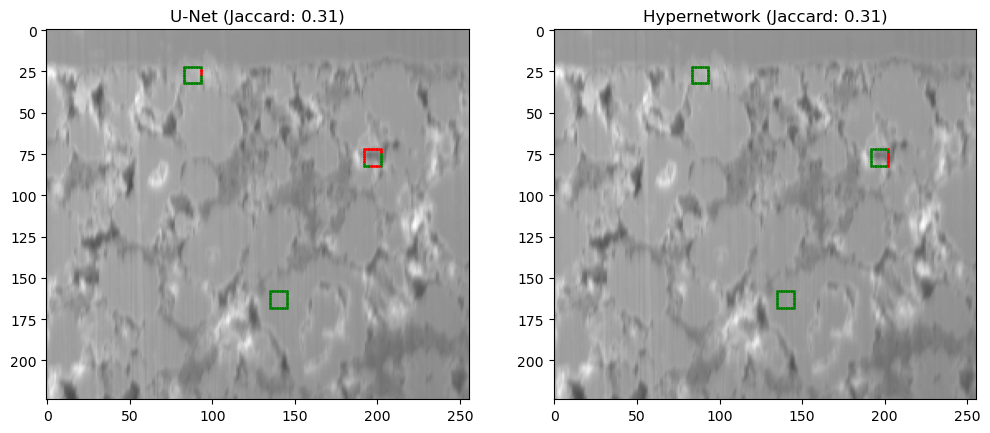

<Figure size 640x480 with 0 Axes>

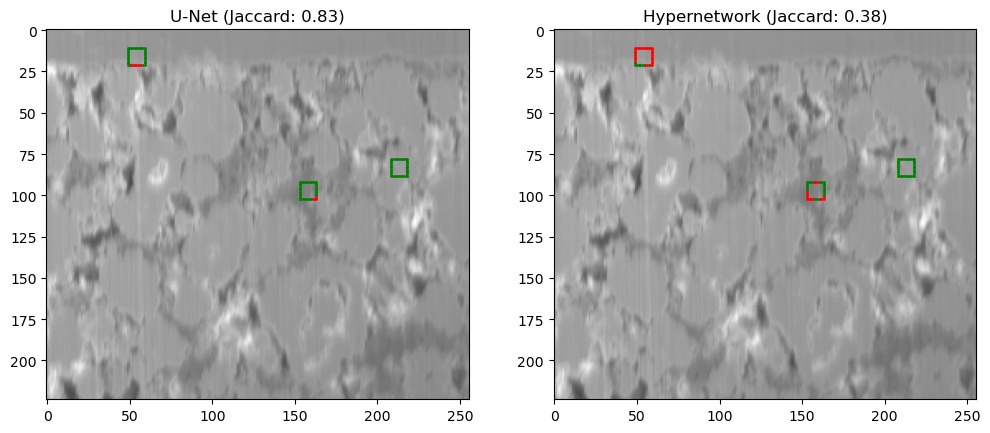

<Figure size 640x480 with 0 Axes>

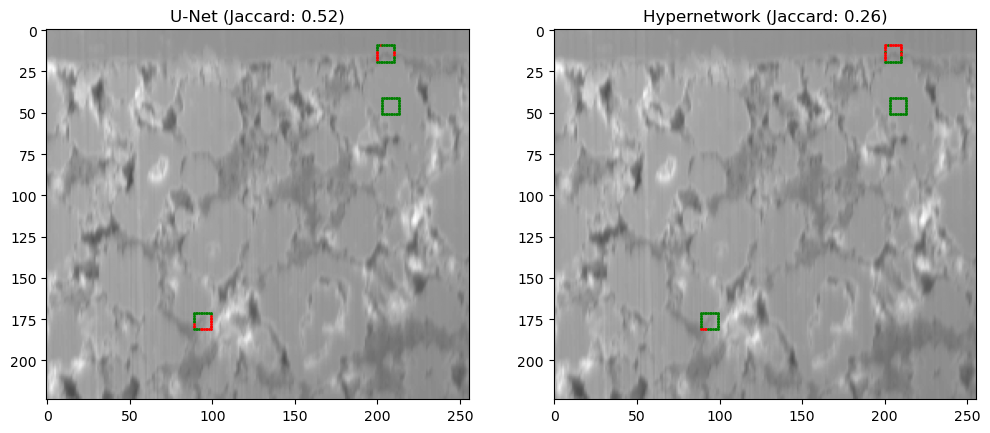

<Figure size 640x480 with 0 Axes>

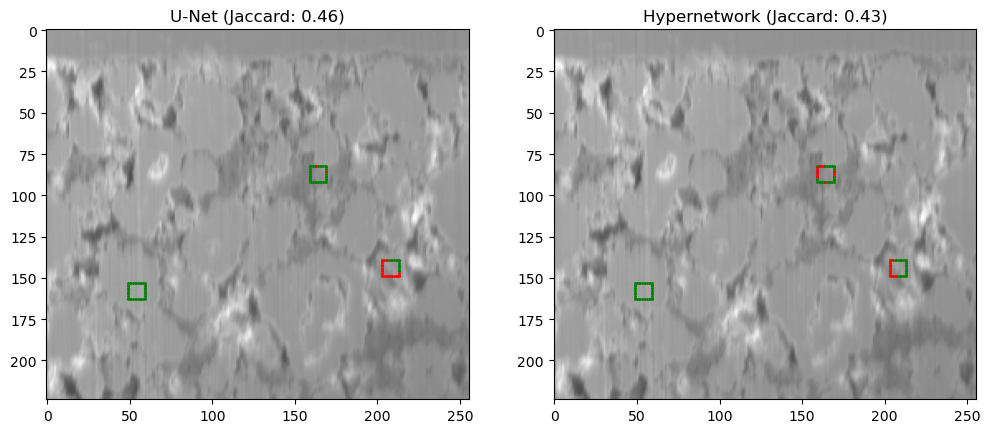

<Figure size 640x480 with 0 Axes>

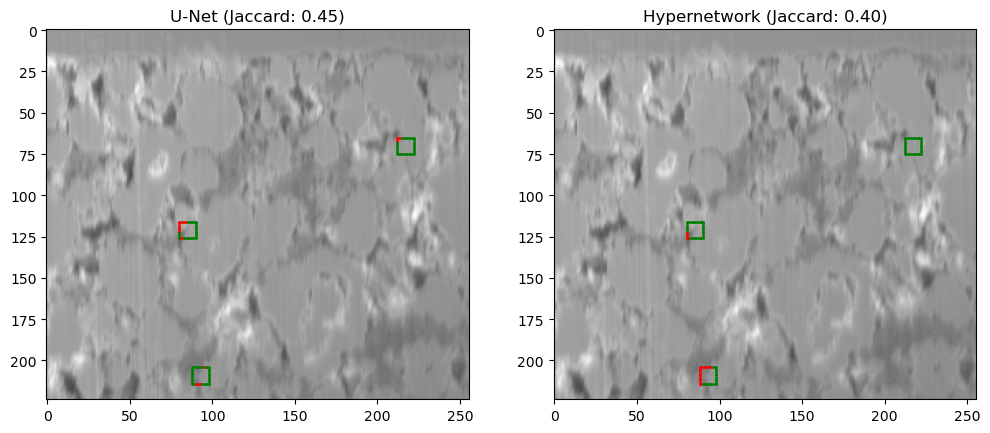

<Figure size 640x480 with 0 Axes>

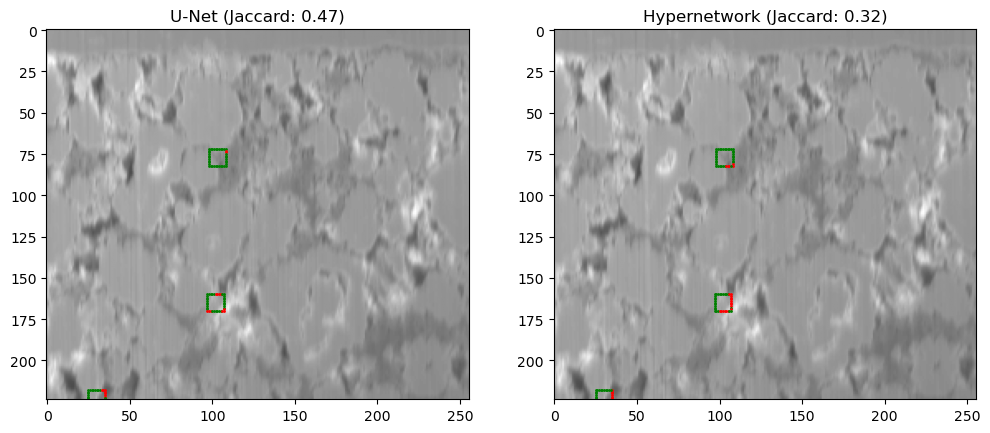

<Figure size 640x480 with 0 Axes>

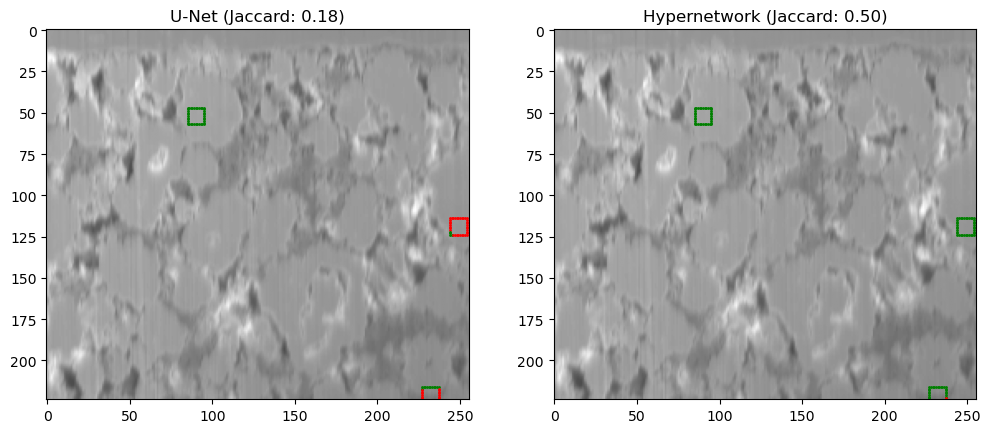

<Figure size 640x480 with 0 Axes>

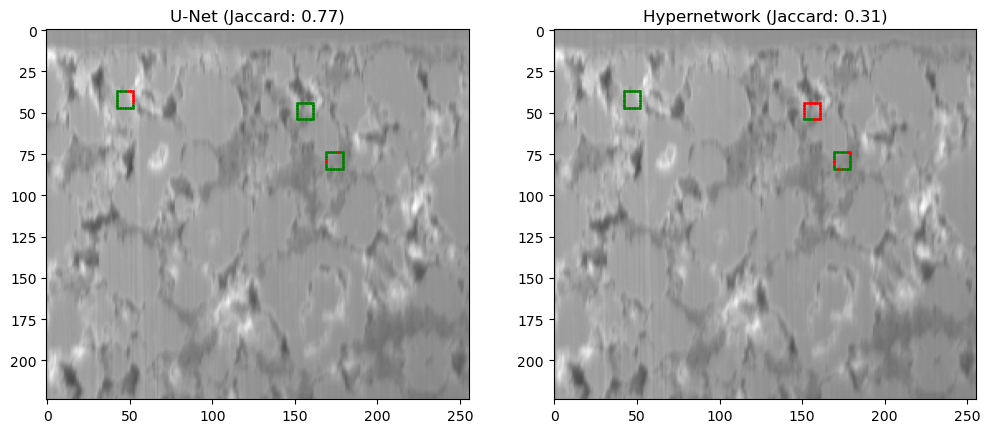

<Figure size 640x480 with 0 Axes>

In [21]:
for key in bound_pixels:
    visualize_unet_predictions(key, bound_pixels, total_unet_true_labels, total_unet_pred_labels, hyp_true_labels, hyp_pred_labels)